In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob
import keras
from keras.utils.np_utils import to_categorical

In [3]:
import tensorflow as tf

cf = tf.ConfigProto()
cf.gpu_options.allow_growth = True
sess = tf.Session(config=cf)

In [10]:
MASK_TRAIN_CALC_PATH = r"D:\Gproject\DataSet\tcia_data\dataset_dir\mask_train\calc\*.png"
MASK_TRAIN_MASS_PATH = r"D:\Gproject\DataSet\tcia_data\dataset_dir\mask_train\mass\*.png"
MASK_TEST_CALC_PATH = r"D:\Gproject\DataSet\tcia_data\dataset_dir\mask_test\calc\*.png"
MASK_TEST_MASS_PATH = r"D:\Gproject\DataSet\tcia_data\dataset_dir\mask_test\mass\*.png"

In [13]:
MASK_TRAIN_CALC_PATHS = glob.glob(MASK_TRAIN_CALC_PATH)
MASK_TRAIN_MASS_PATHS = glob.glob(MASK_TRAIN_MASS_PATH)
MASK_TRAIN_PATHS = MASK_TRAIN_CALC_PATHS + MASK_TRAIN_MASS_PATHS
MASK_TEST_CALC_PATHS = glob.glob(MASK_TEST_CALC_PATH)
MASK_TEST_MASS_PATHS = glob.glob(MASK_TEST_MASS_PATH)
MASK_TEST_PATHS = MASK_TEST_CALC_PATHS + MASK_TEST_MASS_PATHS

In [84]:
print(len(MASK_TRAIN_CALC_PATHS),len(MASK_TRAIN_MASS_PATHS) ,len(MASK_TRAIN_PATHS))
print(len(MASK_TEST_CALC_PATHS),len(MASK_TEST_MASS_PATHS),len(MASK_TEST_PATHS))

1519 1226 2745
325 365 690


In [16]:
# # 이미지의 평균 구하기
# img_x = 0
# img_y = 0
# for i in MASK_TRAIN_PATHS:
#     img = plt.imread(i)
#     img_x += img.shape[0]
#     img_y += img.shape[1]

# # 410.0998178506375
# print(img_x/2745)

# # 421.0761384335155
# print(img_y/2745)

1125724
1155854


In [14]:
#train set
count = 0
dsize =(224,224)
train_x = np.array
train_y = np.array([])

for i in MASK_TRAIN_PATHS:
    
    img = cv.imread(i,cv.COLOR_RGB2BGRA)
    
    if img.shape[0] > dsize[0] and img.shape[1] > dsize[1]:
        resize_img = cv.resize(img,dsize,interpolation = cv.INTER_CUBIC)
        
    else:
        resize_img = cv.resize(img,dsize,interpolation = cv.INTER_AREA)

    resize_img_newaxis = resize_img[np.newaxis,...]
    count +=1
    #print(count)
    
    if count == 1:
        train_x = resize_img_newaxis
    else:
        train_x = np.concatenate((train_x, resize_img_newaxis))
    
    abnormality = i.split("\\")[-1][:4]
    if abnormality == 'Calc':
        train_y = np.concatenate((train_y,[0]))
    elif abnormality == 'Mass':
        train_y = np.concatenate((train_y,[1]))
    else:
        print(i)
        
train_x = train_x[...,np.newaxis]
print(train_x.shape)
print(train_y.shape)

(2745, 224, 224, 1)
(2745,)


In [12]:
len(MASK_TRAIN_PATHS)

0

In [15]:
train_y = to_categorical(train_y,num_classes=2,dtype=np.uint8)

In [16]:
#val set
count = 0
dsize =(224,224)
test_x = np.array
test_y = np.array([])

for i in MASK_TEST_PATHS:
    
    img = cv.imread(i,cv.COLOR_RGB2BGRA)
    
    if img.shape[0] > dsize[0] and img.shape[1] > dsize[1]:
        resize_img = cv.resize(img,dsize,interpolation = cv.INTER_CUBIC)
        
    else:
        resize_img = cv.resize(img,dsize,interpolation = cv.INTER_AREA)

    resize_img_newaxis = resize_img[np.newaxis,...]
    count +=1
    #print(count)
    
    if count == 1:
        test_x = resize_img_newaxis
    else:
        test_x = np.concatenate((test_x, resize_img_newaxis))
    
    abnormality = i.split("\\")[-1][:4]
    if abnormality == 'Calc':
        test_y = np.concatenate((test_y,[0]))
    elif abnormality == 'Mass':
        test_y = np.concatenate((test_y,[1]))
    else:
        print(i)
test_x = test_x[...,np.newaxis]
print(test_x.shape)
print(test_y.shape)

(690, 224, 224, 1)
(690,)


In [17]:
test_y = to_categorical(test_y,num_classes=2,dtype=np.uint8)

In [23]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import callbacks
from keras.applications import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator

In [19]:
csv_logger = callbacks.CSVLogger('./log_classification/200520_00log.scv')

In [20]:
def bulid_ResNet50V2(input_shape=None):
    base_model = ResNet50V2(include_top=False, weights=None, input_shape=input_shape)

    x = base_model.output
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    
    x = layers.Dense(512, activation='relu', name='fc1')(x)
    x = layers.Dense(256, activation='relu', name='fc2')(x)
    main_output = layers.Dense(2, name='fc3',activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=main_output, name='resnet50_v2')

    return model

In [21]:
model = bulid_ResNet50V2(input_shape=(224,224,1))

In [22]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy, metrics=['acc'])

In [17]:
train_x.shape

(2745, 224, 224, 1)

In [24]:
train_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# train_root = r"D:\Gproject\DataSet\tcia_data\dataset_dir\mask_train"
# test_root = r"D:\Gproject\DataSet\tcia_data\dataset_dir\mask_test"
#train_generator = train_datagen.flow_from_directory(train_root,target_size=(244,244),batch_size=16,interpolation="bilinear")
#test_generator = train_datagen.flow_from_directory(test_root,target_size=(244,244),batch_size=16,interpolation="bilinear")

train_generator = train_datagen.flow(x=train_x ,y=train_y,batch_size=16)
test_generator = test_datagen.flow(x= test_x,y=test_y,batch_size=16)

In [25]:
hist = model.fit(train_generator,steps_per_epoch=200,
                 epochs=40,validation_data=(test_generator),validation_steps=20,
                 callbacks=[csv_logger])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/40
200/200 [==============================] - 40s 200ms/step - loss: 0.7282 - acc: 0.6279 - val_loss: 4.7626 - val_acc: 0.6125
Epoch 2/40
200/200 [==============================] - 27s 134ms/step - loss: 0.6247 - acc: 0.6580 - val_loss: 3.5832 - val_acc: 0.4531
Epoch 3/40
200/200 [==============================] - 27s 137ms/step - loss: 0.5770 - acc: 0.7181 - val_loss: 5.7475 - val_acc: 0.4248
Epoch 4/40
200/200 [==============================] - 26s 132ms/step - loss: 0.5223 - acc: 0.7463 - val_loss: 3.8078 - val_acc: 0.4875
Epoch 5/40
200/200 [==============================] - 26s 132ms/step - loss: 0.4845 - acc: 0.7724 - val_loss: 3.8658 - val_acc: 0.4542
Epoch 6/40
200/200 [==============================] - 27s 133ms/step - loss: 0.4838 - acc: 0.7651 - val_loss: 0.5423 - val_acc: 0.7781
Epoch 7/40
200/200 [==============================] - 26s 132ms/step - loss: 0.4427 - acc: 0.79

In [26]:
model.save(r"./log_classification/200520_00model.h5")

In [27]:
csv_logger = callbacks.CSVLogger('./log_classification/200520_01log.scv')

In [28]:
hist01 = model.fit(train_generator,steps_per_epoch=200,
                 epochs=40,validation_data=(test_generator),validation_steps=20,
                 callbacks=[csv_logger])

Epoch 1/40
200/200 [==============================] - 26s 132ms/step - loss: 0.2474 - acc: 0.9042 - val_loss: 1.4665 - val_acc: 0.7000
Epoch 2/40
200/200 [==============================] - 26s 131ms/step - loss: 0.2428 - acc: 0.9023 - val_loss: 0.4201 - val_acc: 0.7719
Epoch 3/40
200/200 [==============================] - 26s 130ms/step - loss: 0.2518 - acc: 0.8980 - val_loss: 0.5356 - val_acc: 0.8039
Epoch 4/40
200/200 [==============================] - 26s 132ms/step - loss: 0.2295 - acc: 0.9076 - val_loss: 0.3620 - val_acc: 0.7969
Epoch 5/40
200/200 [==============================] - 27s 133ms/step - loss: 0.2349 - acc: 0.9051 - val_loss: 1.2909 - val_acc: 0.7059
Epoch 6/40
200/200 [==============================] - 26s 132ms/step - loss: 0.2520 - acc: 0.9001 - val_loss: 0.7592 - val_acc: 0.8125
Epoch 7/40
200/200 [==============================] - 26s 131ms/step - loss: 0.2144 - acc: 0.9220 - val_loss: 0.8009 - val_acc: 0.7614
Epoch 8/40
200/200 [==============================] - 2

In [29]:
model.save(r"./log_classification/200520_02model.h5")

In [54]:
hist02 = model.fit(train_generator,steps_per_epoch=200,
                 epochs=120,validation_data=(test_generator),validation_steps=20,
                 callbacks=[csv_logger])

Epoch 1/120
200/200 [==============================] - 26s 129ms/step - loss: 0.1395 - acc: 0.9483 - val_loss: 1.7537 - val_acc: 0.8156
Epoch 2/120
200/200 [==============================] - 26s 129ms/step - loss: 0.1472 - acc: 0.9511 - val_loss: 1.3742 - val_acc: 0.8500
Epoch 3/120
200/200 [==============================] - 26s 132ms/step - loss: 0.1423 - acc: 0.9502 - val_loss: 0.7597 - val_acc: 0.8072
Epoch 4/120
200/200 [==============================] - 28s 138ms/step - loss: 0.1440 - acc: 0.9448 - val_loss: 1.9964 - val_acc: 0.8438
Epoch 5/120
200/200 [==============================] - 27s 133ms/step - loss: 0.1371 - acc: 0.9502 - val_loss: 0.7365 - val_acc: 0.8137
Epoch 6/120
200/200 [==============================] - 26s 132ms/step - loss: 0.1456 - acc: 0.9464 - val_loss: 2.0269 - val_acc: 0.7688
Epoch 7/120
200/200 [==============================] - 26s 132ms/step - loss: 0.1350 - acc: 0.9493 - val_loss: 0.2383 - val_acc: 0.8464
Epoch 8/120
200/200 [===========================

In [55]:
model.save(r"./log_classification/200520_02model.h5")

In [32]:
# history 0~ 40
history00 = hist.history

In [56]:
history01 = hist01.history
history02 = hist02.history

In [39]:
import pandas as pd

In [57]:
history00_dp = pd.DataFrame(history00)
history01_dp = pd.DataFrame(history01)
history02_dp = pd.DataFrame(history02)

In [60]:
history = pd.merge(history00_dp,history01_dp,how='outer')
history = pd.merge(history,history02_dp,how='outer')

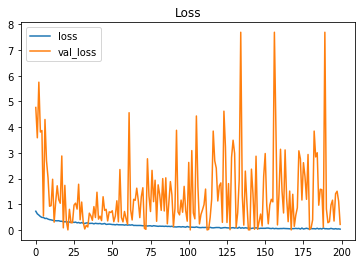

In [71]:
plt.title("Loss")


plt.plot(history["loss"],label ="loss")
plt.plot(history["val_loss"],label="val_loss")
plt.legend()

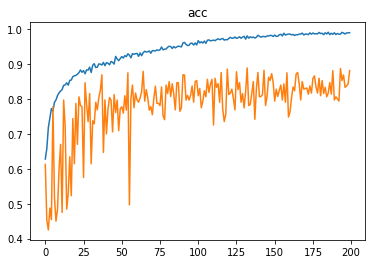

In [73]:
plt.title("acc")
plt.plot(history["acc"],label="acc")
plt.plot(history["val_acc"],label="val_acc")

In [63]:
test_x = test_x/255



In [87]:
test_y[324]

array([1, 0], dtype=uint8)

In [81]:
b = model.evaluate(test_x,test_y)

690/690 [==============================] - 2s 2ms/step


In [82]:
b

[1.4123134644354518, 0.8666666746139526]

In [67]:
history.to_csv(r"./log_classification/200520_total_log.csv")

In [89]:
model.evaluate(test_x[:324],test_y[:324])

324/324 [==============================] - 1s 4ms/step


[2.4414708044999394, 0.790123462677002]

In [90]:
model.evaluate(test_x[324:],test_y[324:])

366/366 [==============================] - 1s 4ms/step


[0.5012561493468772, 0.9344262480735779]